# Exercise 4: Machine Learning Methods

In this exercise, we will experiment with Multi-Layer Perceptron (MLP) and Convolutional Neural Network (CNN) models.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from tqdm import tqdm
# Add current directory to path to import helpers if needed
sys.path.append(os.getcwd())
try:
    from helpers import *
    from MLP import *
    from cnn import *
    from xg import *
    from mlp_experiments import *
    from image_experiments import *
except ImportError:
    print("helpers.py not found or error importing")

## 2. Seeding

In [4]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(42)

# 6. Multi-Layer Perceptrons
## 6.1 Optimization of an MLP
### 6.1.1 Task
Implement a training pipeline from scratch. 
Model: 6 layers (includes input but not output -> 7 nn.Linear instances). Activation: ReLU. Batch Norm before activation.
Default parameters provided in code.

### batchnorm

 Deep Dive: Understanding BatchNorm

BatchNorm is a crucial normalization technique that helps with training stability and speed. Let's understand it deeply:

**The Equation**
For input $x$ with shape $(N, C)$ where $N$ is batch size and $C$ is number of features:

$$y = \frac{x - \mathbb{E}[x]}{\sqrt{\text{Var}[x] + \epsilon}} \cdot \gamma + \beta$$

Where:
- $\mathbb{E}[x]$ and $\text{Var}[x]$ are computed **per-feature across the batch** (mean/var over the $N$ dimension)
- $\epsilon$ is a small constant for numerical stability (default: 1e-5)
- $\gamma$ and $\beta$ are **learnable** scale and shift parameters (one per feature)

**Key Principle**
BatchNorm **normalizes each feature independently** by computing statistics across the batch dimension. This:
1. **Reduces internal covariate shift** - keeps activations stable as network learns
2. **Allows higher learning rates** - less sensitive to initialization
3. **Acts as regularization** - adds noise through batch statistics

how it works:
1. center: **in training**, center each feature with stats of batch + update EMA of global mean and ar to get an estiamte of the overall mean and var of data. **in evall**, center the data *as though* its mean and var were the global ones. 
2. scale each feature with learnt param gamma and beta. 

### 6.1.2 Questions
1. **Learning Rate**: Train with 1, 0.01, 0.001, 0.00001. Plot validation loss.
2. **Epochs**: Train for 100 epochs. Plot loss.
3. **Batch Norm**: Add batch norm. Compare.
4. **Batch Size**: 1, 16, 128, 1024.

#### 6.1.2.1 Learning rates

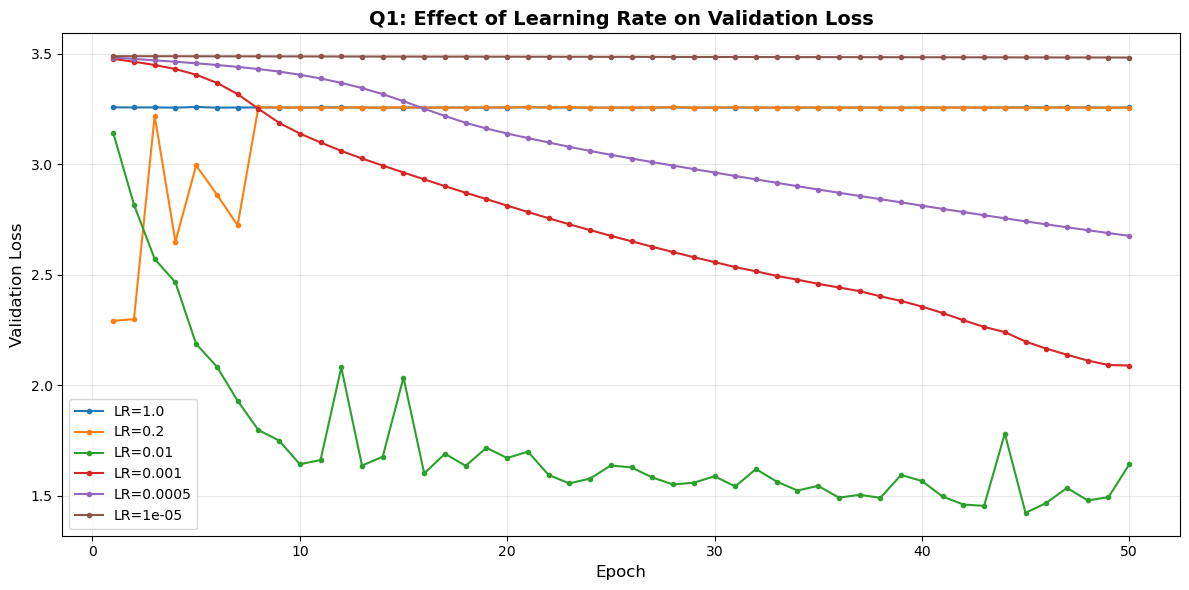

In [7]:
# Usage
q1 = Q_1(run_quiet=True)
q1.run_experiment()

we analyse the smoothness, slope and trend of each plot. we start with the 'sucessful' cases where the loss meaningfully decreased.   
1. for a learning rate of `1e-3` we see a very smooth plot suggesting a stable improvment from epoch to epoch, with no overshooting of the 'correct' direction in the loss landscape. the fact that the plot has a constant slope, suggests trianing could have go on for longer.
2. with a lr of `1e-2` we see that the loss decreases shaply, meaning the model was able to take large steps in the overall correct direction, but near the end began to overshot in some directions. this is the reason many training schedules decrease the lr near the end, when smaller steps are needed. we note this is the only slope that seemed to saturate, suggesting we are not far from the global minimum. 

3. the plot for `1e-5` and `1.0` were both stuck at a constant value.
intuitively, we say that a lr of `1.0` is too large, but we need the plot for `0.2` to correctly diagnose it: we see that with a large lr, there is a change in the val loss in the first few epochs but then it flatlines. we suspect that this is a case where all the neurons are 'dead', and the relu's are outputting only 0, preventing the model from improving.
4. in contrast, the 1e-5 plot is at a differnet constant value, and we suspect this is the original val loss by the random initalisation, and dmeonstarates that the lr is too small (we scale the grads by the lr). we see this from the fact that the `1e-3` plot starts from the same point, and that the `5e-4` plot is between the `1e-3` and `1e-5` plots.

#### 6.1.2.2  100 epochs

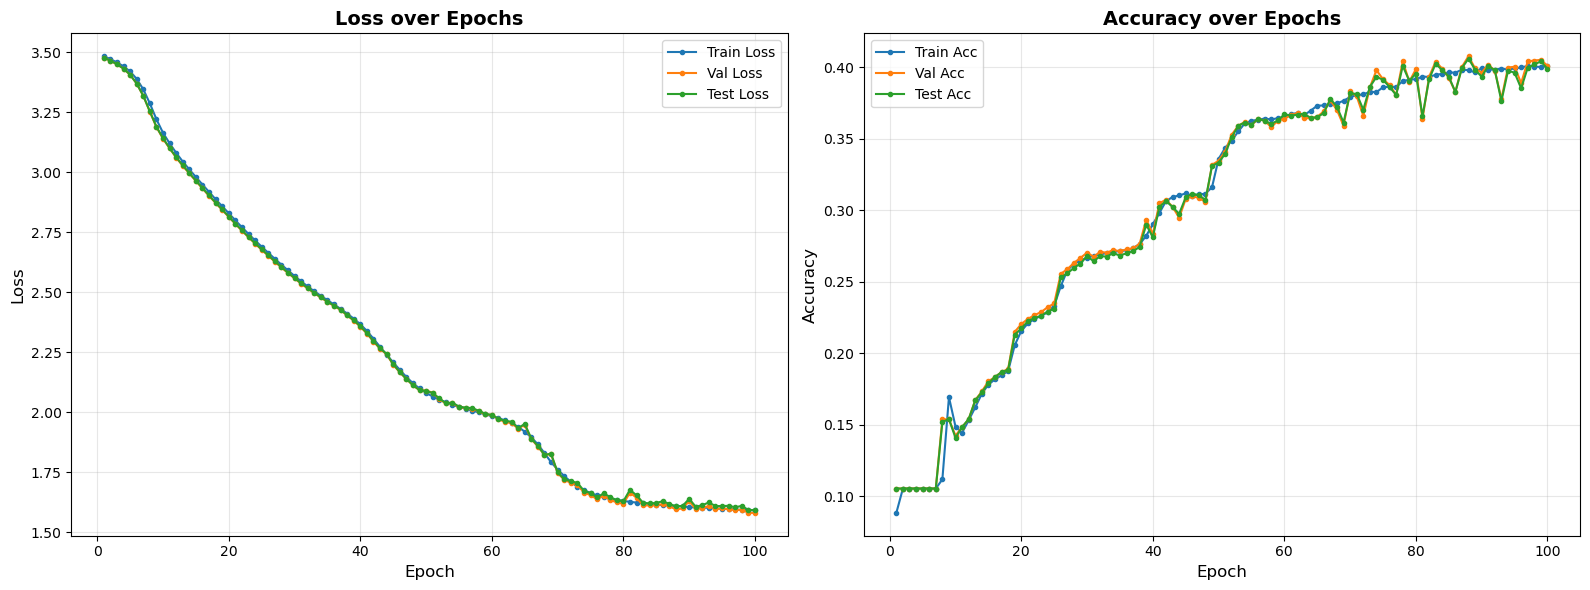

In [8]:
q2_exp = Q2_Experiment(num_epochs=100, run_quiet=True)
q2_exp.run()
q2_res = Q2_Results(q2_exp)
q2_res.plot()

as indicated in question 1, with a lr of 1e-3 we have stable training, even up to 100 epochs. the train, test and val loss  / accuracy stay in line, indicating we aren't suffering from overfitting, although the val and test acc became less stable towards the end of trianing, even as the loss remained stable, indicating the model was stochastically changing its predicitons on a subset of the data. we suspect that if we had measured AUROC, we would have had a more stable metric, since if a subset of samples with borderline logits keep getting a different class, the accuracy will change, but the AUROC would remain stable. 

#### 6.1.2.3 adding batch norm

In [9]:
q3_exp = Q2_Experiment(num_epochs=100,use_batch_norm = True, run_quiet=True)
q3_exp.run()

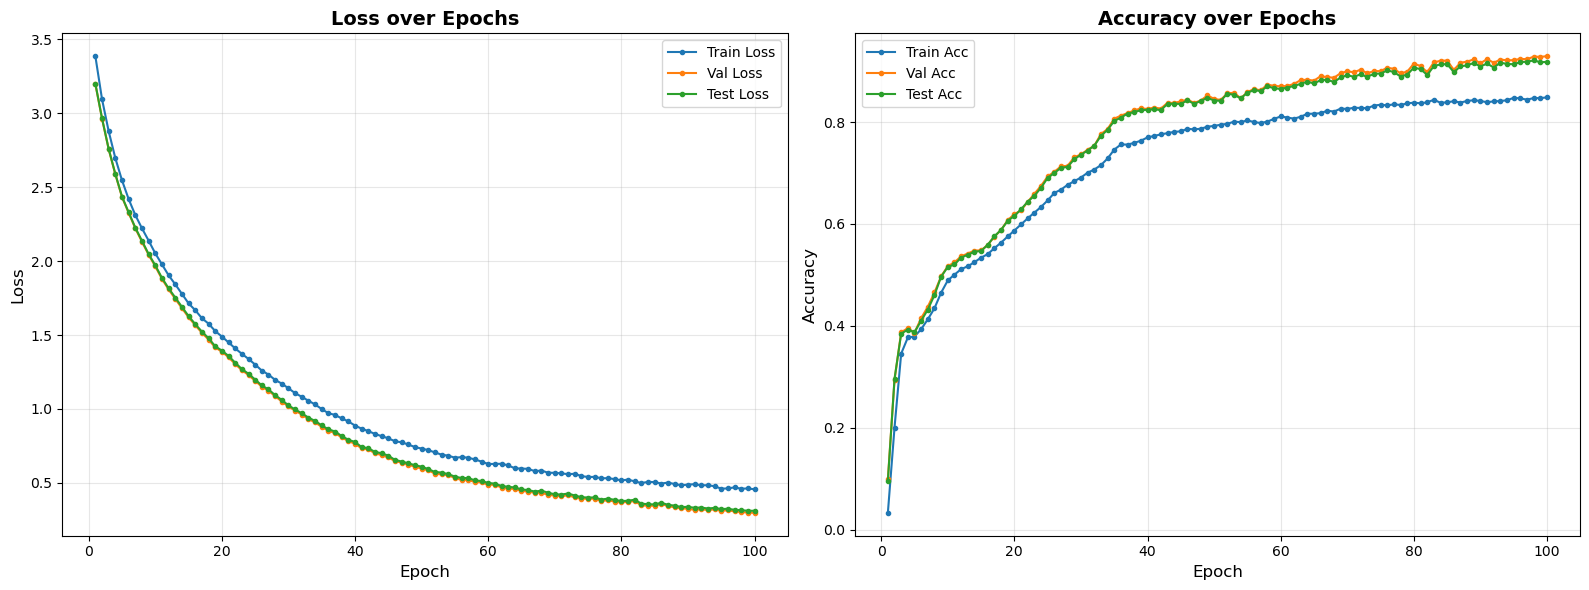

In [10]:
q3_res = Q2_Results(q3_exp)
q3_res.plot()

we see substantially better performance with batch norm:
the final loss goes down to 0.5 vs 1.5 and the **accuracy doubles** to 80%!
the batch norm paper (https://arxiv.org/abs/1502.03167) points to a few benefits of batch norm that could explian this:
1. preventing 'internal covariate shift' -> the input to every layer is centered, giving the model an easier target to adapt to.
2.  more importantly, since the input is centered, there can never be a case where the entire input to a relu is negative ('dead neuron'), menaing the network is probably using more of its weights.

we note the that the test and val performance is superior to the training performance. this is probably explianed by the fact that in eval, the model centers the data relative to the entire trianing data (via the EMA), meaning that it has a stronger inductive bias. during training, if a mini batch happens to have several similar samples, the model throws out some information since it centers them relative to each other.


#### 6.1.2.4 Batch Size

In [ ]:
q4_exp = Q4_Experiment(seed=42, run_quiet=True); q4_exp.run()

In [32]:
q4_res = Q4_Results(q4_exp); q4_res.print_iterations_table()

| Batch Size | Iterations per Epoch |
|------------|----------------------|
| 1          | 106897               |
| 16         | 6682                 |
| 128        | 836                  |
| 1024       | 105                  |


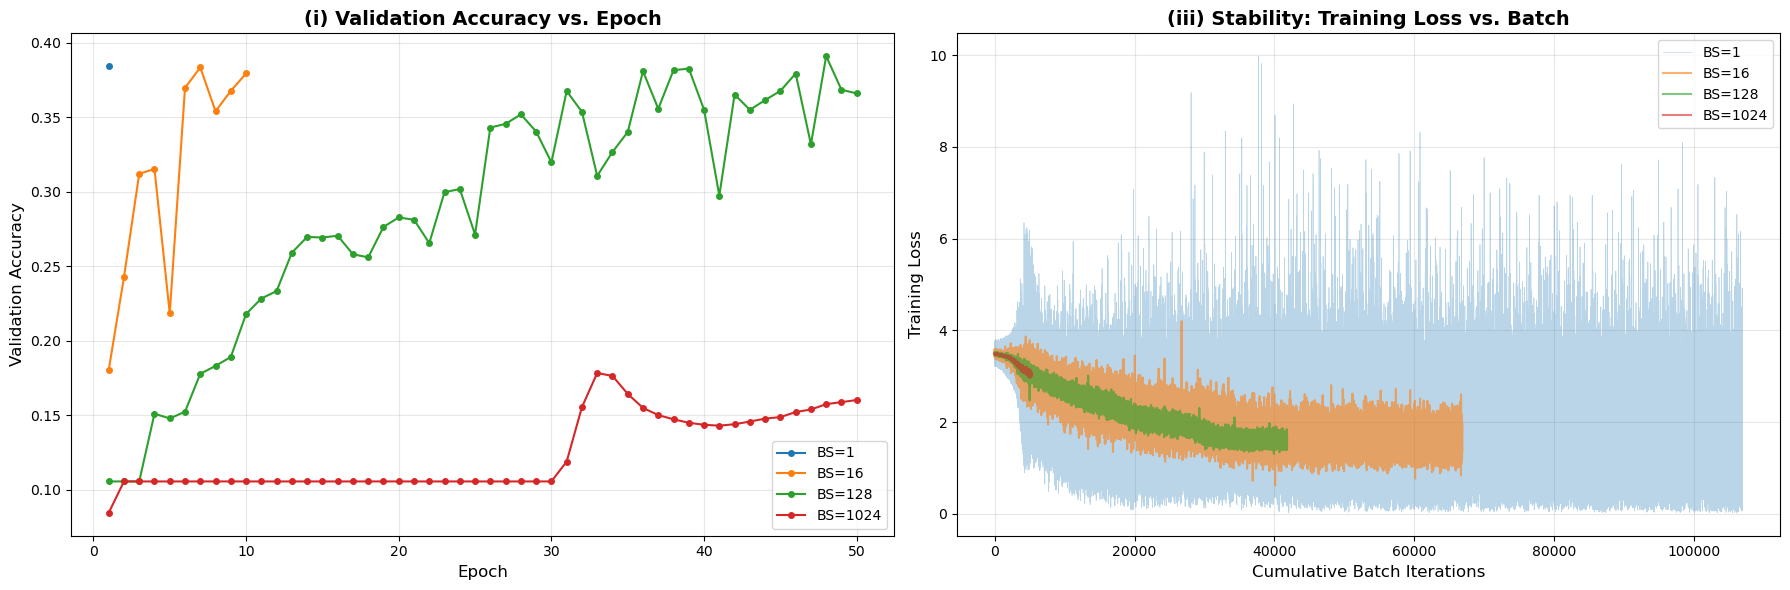

In [33]:
q4_res.plot()

in this analysis we hold the lr constant, and adjust only the batch size. an immediate result is that the differnet configurations have **vastly different numbers of learning steps**: the first model took **100k** steps, while the last (batch size 1024) took `50 * 105 = 5000`, a 20 fold differnce.
in general, the larger the bacth size the more 'trustworthy' the gradiants at a particualr step, and indded we can see that the larger the batch size, the more stable (smaller varinace) the loss. 
we see that for the batch size 16 and 128, the model acheives the **'max' accuracy** of around 40% **after at least 40_000 steps**.  
we saw the smae thing in questions 2 and 3, where we used the same lr but a batch size of 256: we trained for 100 epochs, giving a total of ~40k steps and acheived maximal accuracy only near the end of training. the corollary of this experiment would be to use a larger learning rate for the larger batch sizes. 

# 6.2 evaluating MLPs with different shapes

| Depth | 1  | 2  | 6  | 10 | 6  | 6  | 6  |
  |-------|----|----|----|----|----|----|-----|
  | Width | 16 | 16 | 16 | 16 | 8  | 32 | 64 |

hparam selection: based on the previous section we applied batch norm and set the batch size to 128 with 50 epochs (getting to the desired 40k trianing steps with an lr of 1e-3)

In [13]:
exp_6_2 = Q6_2_Experiment(run_quiet=True)
exp_6_2.run()

#### 6.2.1 best and worst

In [14]:
# Assuming q6_2_exp has already been run
q6_2_res = Q6_2_Results(exp_6_2)

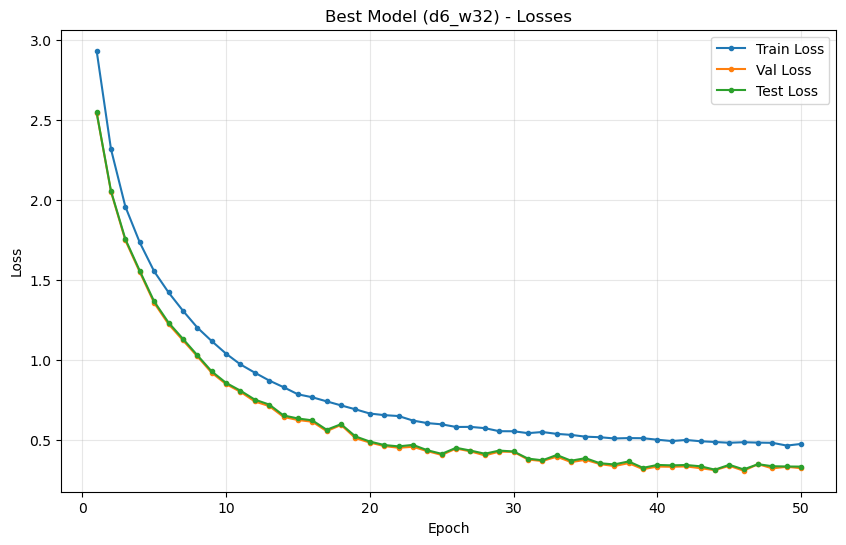

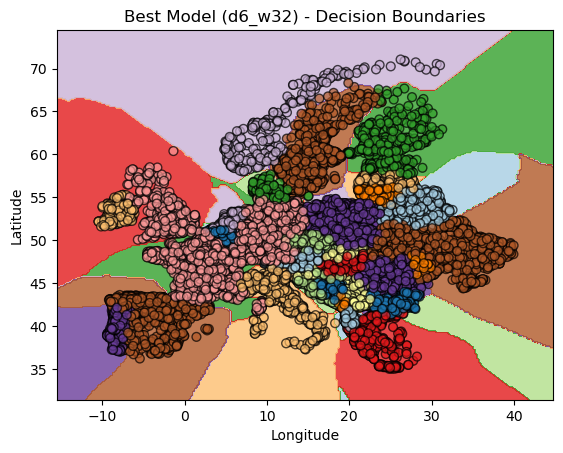

In [15]:
q6_2_res.plot_best_model()

we see this model generalised exceedingly well. reaching the lowest loss seen in previous sections. moreover the test and val loss are even lower (see discussion of section 6.1.2.4). we especially note the complex shape of the descision boundaries, showing that the network is sufficiently expressive to capture complex and non linear boundaries.

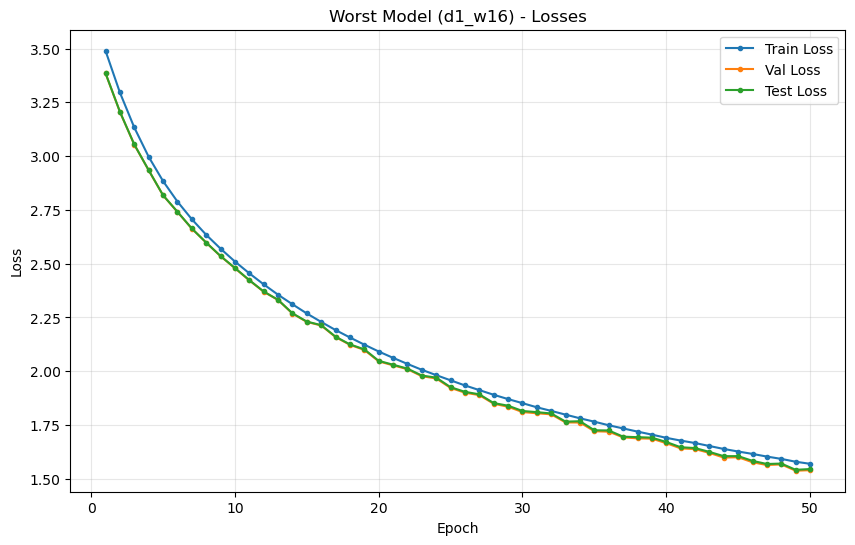

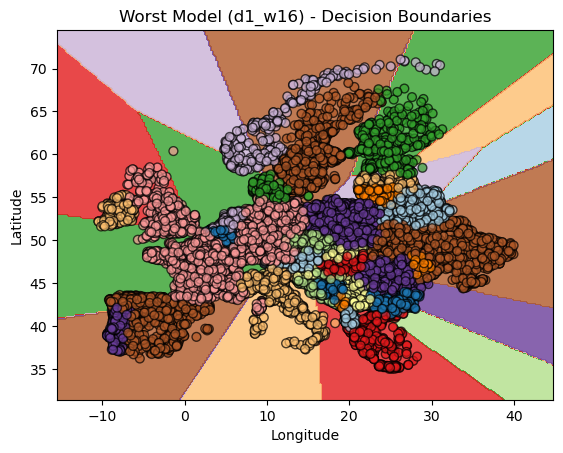

In [16]:
q6_2_res.plot_worst_model()

in contrast, the shallow model underfit the data, acheiving a loss of only 1.75 on both train and test sets. we see that the decision boundaries are coarse and straight, indicating the model runs out of epxressive capacity. indeed, this is similar to our discussion of epxressivity of trees, under the understanding that each neuron devides space with a hyper plane.

according to Montúfar et al. and Serra et al. the upper bound on the number of linear regions $R_{max}$ of a ReLU network with input dimension \(n_0\) and a single hidden layer of width \(n_1\) can be written as

$R_{max} \;\le\; \sum_{k=0}^{\min(n_0,\,n_1)} \binom{n_1}{k}$

where $\binom{n_1}{k}$ are binomial coefficients that count the number of regions a set of $n_1$ hyperplanes can define in $\mathbb{R}^{n_0}$ — this is a standard combinatorial upper bound on the number of piecewise-linear regions of a ReLU network.

for the given model with $n_0=2$ and one hidden ReLU layer of width $n_1=16$, this translates to

$R_{max} \;\le\; \binom{16}{0} + \binom{16}{1} + \binom{16}{2} = 1 + 16 + 120 = \boxed{137}$

so the network can partition the 2-dimensional input space into at most **~137 linear regions** in the theoretical worst case.


https://proceedings.neurips.cc/paper_files/paper/2014/file/fa6f2a469cc4d61a92d96e74617c3d2a-Paper.pdf  
https://openreview.net/forum?id=Sy-tszZRZ


#### 6.2.2 effect of depth

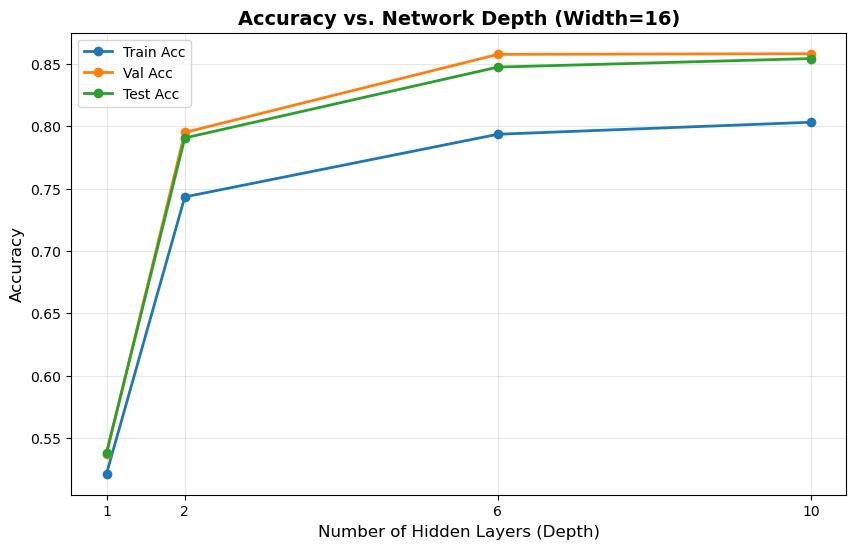

In [18]:
# Q6.2.3: Depth Analysis
q6_2_res.plot_depth_analysis()

in our case we  seen an increase in the accuarcay as the number of layers increases. on the one hand, further layers increase the models epxressive capacity. allowing it to avoid underfitting. the corallary is that it also enables it to overfit, although that doens't seem to have happened here. moreover, had we tested netwroks with tens of layers, we may reach thedepth  limit of vanilla neural network where additional layers do not provide further benefit dues to vanishing/exploding  gradiants. it's possible that the diminishing returns from adding layers 7-10 is a precursor of this phenomenom. 

#### effect of width

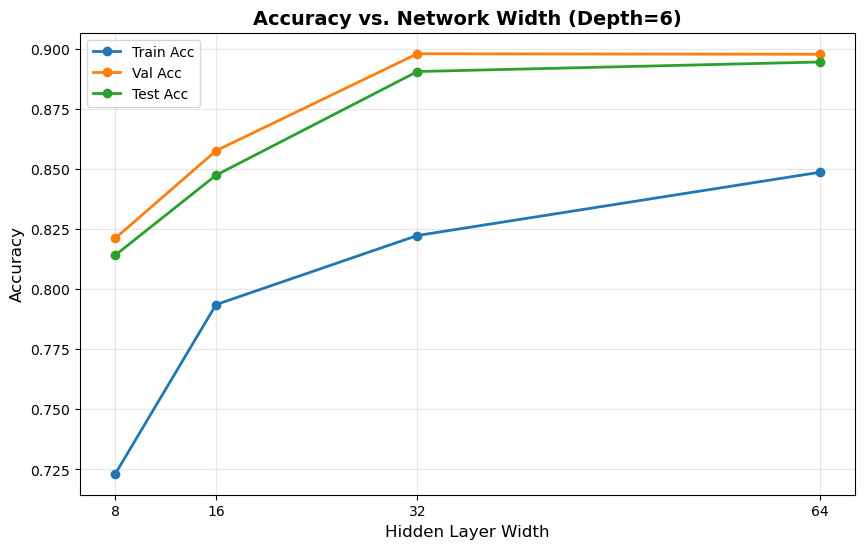

In [19]:
# Q6.2.4: Width Analysis
q6_2_res.plot_width_analysis()

interestingly, increasing the width leads to better results in our case. perhaps since increasing the width increases the epxressivity of the network (although not as drastically as incresing the depth), and avoids the downside of vanishing / exploding gradiants. 

#### exploding grads

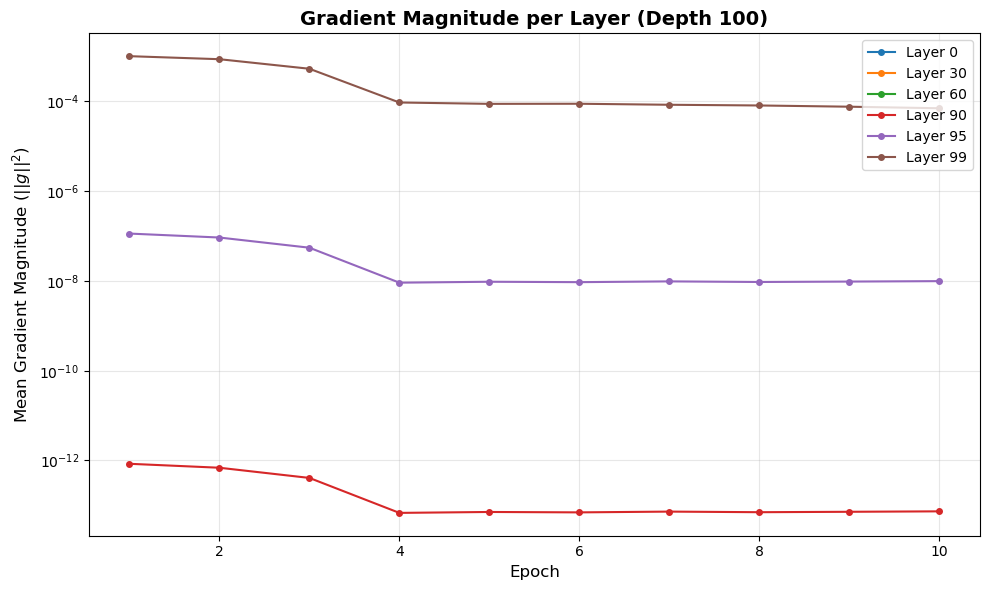

In [20]:
grads_exp = Q6_2_5_Experiment(run_quiet=True)
grads_exp.run()
grads_plots = Q6_2_5_Results(grads_exp)
grads_plots.plot()

In [21]:
grads_exp.trainer.history['grad_norms'][60]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

we see that indeed, already after 10 layers, the gradaints are tiny (1e-13), and that by layer 60 they are 0 (smaller than machine precision). a solution might be to add residual connections between the layers, since it sets a **lower bound** on the norm of the gradiants at 1.

# CNNs

 - Learning rates: [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
  - Batch size: 32
  - Epochs: 1

## train models

In [ ]:
set_seed(42)
DATA_PATH = 'whichfaceisreal'

xgb_exp = XGBExperiment(path=DATA_PATH, seed=42, run_quiet=True); xgb_exp.run()
scratch_exp = ScratchExperiment(path=DATA_PATH, seed=42, run_quiet=True); scratch_exp.run()
probe_exp = LinearProbeExperiment(path=DATA_PATH, seed=42, run_quiet=True); probe_exp.run()
finetune_exp = FineTuneExperiment(path=DATA_PATH, seed=42, run_quiet=True); finetune_exp.run()
# 5. (BONUS) sklearn LogisticRegression on ResNet features
sklearn_exp = SklearnProbeExperiment(path=DATA_PATH, seed=42, run_quiet=True); sklearn_exp.run()

In [24]:
aggregator = Section7Aggregator({
  'xgb': xgb_exp,
  'scratch': scratch_exp,
  'linear_probe': probe_exp,
  'finetune': finetune_exp,
  'sklearn_probe': sklearn_exp  # Uncomment for bonus
})

## 7.6.1 analyze results

In [26]:
# Create results handler
results = Section7Results(aggregator, path=DATA_PATH)

# Q7.6.1: Print summary table (best 2 per baseline + worst overall)
results.print_summary_table()

SECTION 7 RESULTS: Best 2 Models per Baseline

XGB:
  1. XGBoost: Test Accuracy = 0.7350

SCRATCH:
  1. lr=0.0001: Test Accuracy = 0.5250
  2. lr=1e-05: Test Accuracy = 0.5000

LINEAR_PROBE:
  1. lr=0.1: Test Accuracy = 0.7325
  2. lr=0.01: Test Accuracy = 0.7150

FINETUNE:
  1. lr=0.0001: Test Accuracy = 0.7475
  2. lr=1e-05: Test Accuracy = 0.7175

SKLEARN_PROBE:
  1. sklearn_LR: Test Accuracy = 0.7150

----------------------------------------------------------------------
WORST OVERALL: finetune / lr=0.01: Test Accuracy = 0.4775


FULL RANKING (all models):
--------------------------------------------------
 1. [finetune    ] lr=0.0001       -> 0.7475
 2. [xgb         ] XGBoost         -> 0.7350
 3. [linear_probe] lr=0.1          -> 0.7325
 4. [finetune    ] lr=1e-05        -> 0.7175
 5. [linear_probe] lr=0.01         -> 0.7150
 6. [sklearn_probe] sklearn_LR      -> 0.7150
 7. [linear_probe] lr=0.001        -> 0.6825
 8. [finetune    ] lr=0.001        -> 0.6475
 9. [linear_probe] lr

1. the **XGB model**, being much smaller than a full resnet, and training on a smaller feature space (`64 X 64`), is able to train reasonably well and pickup some underling signal, acheiving near top level accuracy.
2. we see that the full **resnet from  scratch** performed badly for all learning rates - being close to random (50%). we suspect the high learning rate fell into a dead relu trap and the low learing rate didn't manage to learn anything meaningful. and this makes sense given that a full resnet has `11 M params` and we took a mere `1,400`  trianing steps. we excpect the model to be roughly at random!
3. for the **fully finetuned** model, `1e-4` and `1e-5` were best. suggesting that the model needed to only gently tweak the weights, requiring a lower learning rate, although `1e-5` was already too low, since in the given number of training steps, the `1e-4` model did better.
4. the **sklearn logistic regressor** trained on the trained resent also did quite well, being only 3% under the very best. this provides a clear baseline, indicating that most of the information needed for transfer learning is readily available in the last layer of the resnet, requiring only a linear transformation.
5. the **trained linear head**, while computing the same logic as the sklearn probe (frozen resnet -> linear transformation -> sigmoid), had different results, depending on the hyper params. it actually did best with a high lr of `0.1` and `0.01`. We assume that given the small number of training steps, it required a high lr to meaningfully adjust its params, while the fact the model was so small kept it stable even under high lr. the last two examples showcase the difference between using the defualt hparams and regularisation of sklearn as opposed to manually tweaking the params. 




### 7.6.2 visualise mistakes

Best model: finetune/lr=0.0001 (acc=0.7475)
Worst model: finetune/lr=0.01 (acc=0.4775)


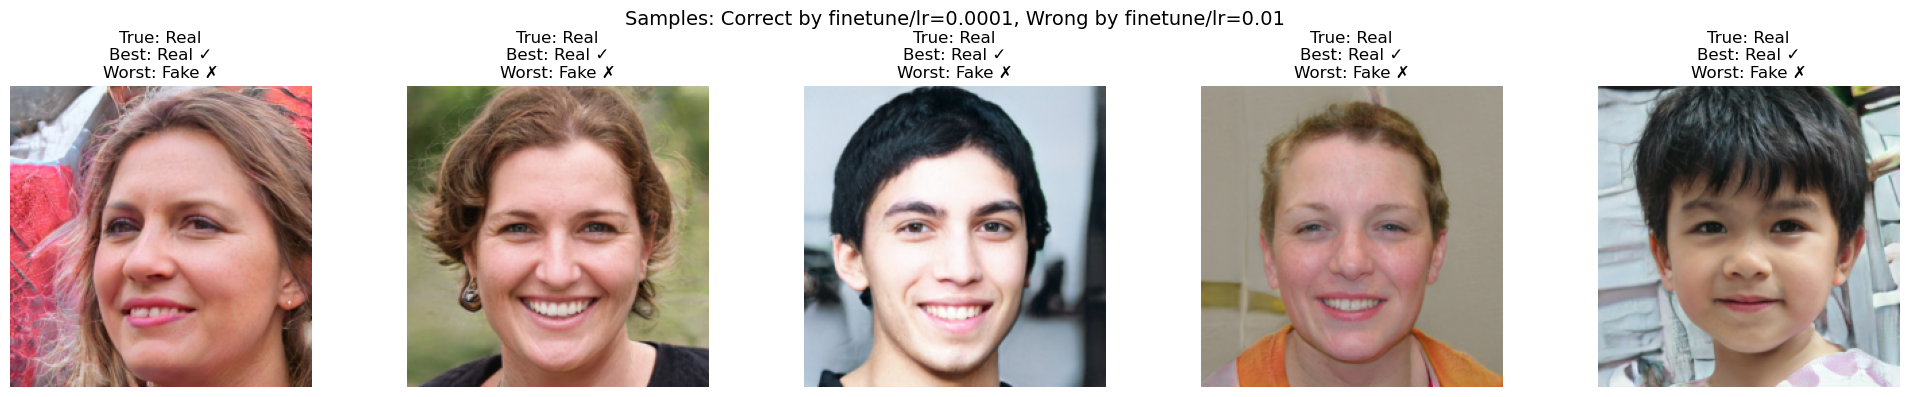

In [27]:
# Q7.6.2: Visualize misclassified samples
results.plot_misclassified_samples(n=5)